### Netflix Comedy TV Series Audience Clustering

#### 1. Project Setup and Configuration

In [14]:
import requests
import pandas as pd
import time
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from nltk.corpus import stopwords
import re
import ast # For safer literal evaluation of string representations of lists
import nltk # For NLTK downloads
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # To suppress specific warnings

# --- Configuration ---
API_KEY = '7f73a5b0d2af01e7d75daa957c10bef0' 
BASE_URL = 'https://api.themoviedb.org/3'
COMEDY_GENRE_ID = 35 # TMDB ID for Comedy TV genre
NETFLIX_NETWORK_ID = 213 # TMDB ID for Netflix Network
NETFLIX_PROVIDER_ID = 8 # TMDB ID for Netflix Watch Provider
TARGET_REGIONS = ['US', 'CA'] # United States, Canada

# Suppress warnings that might appear from KMeans when n_init is auto
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')

print("--- Project Setup Complete ---")

--- Project Setup Complete ---


#### 2. Data Acquisition - Fetching Netflix Comedy Series Metadata

In [17]:
# --- Helper function for API calls with rate limiting and error handling ---
def make_tmdb_request(endpoint, params):
    url = f"{BASE_URL}/{endpoint}"
    params['api_key'] = API_KEY
    try_count = 0
    max_tries = 5

    while try_count < max_tries:
        try:
            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                return response.json()
            elif response.status_code == 429: # Too Many Requests
                print(f"Rate limit hit for {endpoint}. Waiting for {try_count*2 + 1} seconds...")
                time.sleep(try_count * 2 + 1)
                try_count += 1
            else:
                print(f"Error {response.status_code} for {endpoint} with params {params}: {response.text}")
                return None
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {url} with error: {e}. Retrying...")
            time.sleep(try_count * 2 + 1)
            try_count += 1
    print(f"Failed after {max_tries} attempts to fetch {url}.")
    return None

print("Phase 1: Starting Data Acquisition...")

# --- Step 1: Discover Netflix Comedy TV Series Across US & Canada ---
all_netflix_comedy_series_basic_info = []
unique_series_ids = set() # To store IDs and prevent duplicates

print("Fetching Netflix Comedy TV series across US and Canada regions...")

for region_code in TARGET_REGIONS:
    print(f"\n--- Fetching for region: {region_code} ---")
    page = 1
    total_pages = 1 # Initialize to enter the loop

    while page <= total_pages and page <= 500: # TMDB discover endpoint maxes out at 500 pages
        params = {
            'with_genres': COMEDY_GENRE_ID,
            'with_networks': NETFLIX_NETWORK_ID,
            'with_watch_providers': NETFLIX_PROVIDER_ID,
            'watch_region': region_code,
            'sort_by': 'popularity.desc',
            'page': page,
            'language': 'en-US'
        }
        data = make_tmdb_request("discover/tv", params)

        if data and 'results' in data:
            current_page_results = data['results']
            if current_page_results:
                for series in current_page_results:
                    if series['id'] not in unique_series_ids:
                        all_netflix_comedy_series_basic_info.append(series)
                        unique_series_ids.add(series['id'])
                total_pages = data['total_pages']
                print(f"  Region {region_code}, Fetched page {page}/{total_pages}. Current total unique series: {len(unique_series_ids)}")
            else:
                print(f"  No more results found on page {page} for region {region_code}. Breaking.")
                break

        else:
            print(f"  Error or no results data for page {page} in region {region_code}. Breaking.")
            break

        page += 1
        time.sleep(0.1)

print(f"\nFinished initial fetch. Total unique Netflix comedy series collected: {len(unique_series_ids)}.")

# --- Ensure df_netflix_comedy is always a DataFrame ---
if all_netflix_comedy_series_basic_info:
    df_netflix_comedy = pd.DataFrame(all_netflix_comedy_series_basic_info)
    df_netflix_comedy.drop_duplicates(subset=['id'], inplace=True)
    print("\nNetflix Comedy Series DataFrame (Basic Info) Head:")
    print(df_netflix_comedy.head())
    print(f"\nNetflix Comedy Series DataFrame (Basic Info) Info:\n{df_netflix_comedy.info()}")
else:
    print("\nNo Netflix comedy series data fetched. Initializing an empty DataFrame for df_netflix_comedy.")
    df_netflix_comedy = pd.DataFrame(columns=[
        'id', 'name', 'overview', 'poster_path', 'vote_average', 'vote_count',
        'popularity', 'first_air_date', 'genre_ids', 'original_language',
        'backdrop_path', 'original_name', 'origin_country'
    ])

# --- Step 2: Gather Detailed Metadata for Netflix Comedy Series ---
all_netflix_comedy_details = []

print("\nStarting to fetch detailed metadata for Netflix comedy series...")

if df_netflix_comedy.empty:
    print("df_netflix_comedy is empty. Skipping detailed metadata fetch.")
    df_netflix_comedy_details = pd.DataFrame()
else:
    for index, series_row in df_netflix_comedy.iterrows():
        series_id = series_row['id']
        
        details_endpoint = f"tv/{series_id}"
        details_params = {'language': 'en-US', 'append_to_response': 'credits'}
        details_data = make_tmdb_request(details_endpoint, details_params)
        
        keywords_endpoint = f"tv/{series_id}/keywords"
        keywords_data = make_tmdb_request(keywords_endpoint, {})
        
        if details_data:
            series_details = {
                'id': details_data.get('id'),
                'name': details_data.get('name'),
                'overview': details_data.get('overview'),
                'tagline': details_data.get('tagline'),
                'first_air_date': details_data.get('first_air_date'),
                'vote_average': details_data.get('vote_average'),
                'vote_count': details_data.get('vote_count'),
                'popularity': details_data.get('popularity'),
                'original_language': details_data.get('original_language'),
                'status': details_data.get('status'),
                'type': details_data.get('type'),
                'number_of_seasons': details_data.get('number_of_seasons'),
                'number_of_episodes': details_data.get('number_of_episodes'),
                'networks': [net['name'] for net in details_data.get('networks', [])],
                'genres': [g['name'] for g in details_data.get('genres', [])],
                'production_companies': [pc['name'] for pc in details_data.get('production_companies', [])],
                'content_rating': None, # Requires separate API call for regional certification
                'top_cast': [],
                'directors': [],
                'writers': [],
                'keywords': []
            }

            if 'credits' in details_data:
                series_details['top_cast'] = [cast_member['name'] for cast_member in details_data['credits'].get('cast', [])[:5]]
                
                for crew_member in details_data['credits'].get('crew', []):
                    if crew_member['job'] == 'Director':
                        series_details['directors'].append(crew_member['name'])
                    elif crew_member['job'] in ['Writer', 'Screenplay', 'Creator', 'Head Writer', 'Executive Producer']:
                        series_details['writers'].append(crew_member['name'])
                series_details['directors'] = list(set(series_details['directors']))
                series_details['writers'] = list(set(series_details['writers']))

            if keywords_data and 'results' in keywords_data:
                series_details['keywords'] = [kw['name'] for kw in keywords_data['results']]

            all_netflix_comedy_details.append(series_details)
            print(f"  Fetched details for: {series_details['name']}")
        else:
            print(f"  Could not fetch details for series ID: {series_id}")
        
        time.sleep(0.1)

    df_netflix_comedy_details = pd.DataFrame(all_netflix_comedy_details)

print(f"\nFinished fetching detailed metadata. Total detailed series: {len(df_netflix_comedy_details)}")
print("\nDetailed Netflix Comedy Series DataFrame Head:")
print(df_netflix_comedy_details.head())
print(f"\nDetailed Netflix Comedy Series DataFrame Info:\n{df_netflix_comedy_details.info()}")

# Save to CSV for backup
if not df_netflix_comedy_details.empty:
    df_netflix_comedy_details.to_csv('netflix_comedy_tv_series_details_US_CA.csv', index=False)
    print("\nData saved to 'netflix_comedy_tv_series_details_US_CA.csv'")
else:
    print("\nNo detailed data to save as df_netflix_comedy_details is empty.")

print("\n--- Phase 1: Data Acquisition Complete ---")

Phase 1: Starting Data Acquisition...
Fetching Netflix Comedy TV series across US and Canada regions...

--- Fetching for region: US ---
  Region US, Fetched page 1/23. Current total unique series: 20
  Region US, Fetched page 2/23. Current total unique series: 40
  Region US, Fetched page 3/23. Current total unique series: 60
  Region US, Fetched page 4/23. Current total unique series: 80
  Region US, Fetched page 5/23. Current total unique series: 100
  Region US, Fetched page 6/23. Current total unique series: 120
  Region US, Fetched page 7/23. Current total unique series: 140
  Region US, Fetched page 8/23. Current total unique series: 160
  Region US, Fetched page 9/23. Current total unique series: 180
  Region US, Fetched page 10/23. Current total unique series: 200
  Region US, Fetched page 11/23. Current total unique series: 220
  Region US, Fetched page 12/23. Current total unique series: 240
  Region US, Fetched page 13/23. Current total unique series: 260
  Region US, Fetch

#### 3. Data Preprocessing and Feature Engineering

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from nltk.corpus import stopwords
import re
import ast # For safe literal evaluation of string representations of lists
import nltk # For NLTK downloads
import numpy as np # Import numpy for numerical operations

# --- Ensure NLTK stopwords are downloaded ---
try:
    stopwords.words('english')
except LookupError:
    print("NLTK stopwords not found. Downloading...")
    nltk.download('stopwords')
    print("NLTK stopwords downloaded.")

print("Starting data preprocessing and feature engineering...")

# --- Load data or ensure 'df_netflix_comedy_details' is in memory ---
try:
    df = pd.read_csv('netflix_comedy_tv_series_details_US_CA.csv')
    print("\nLoaded data from 'netflix_comedy_tv_series_details_US_CA.csv'")

    # Convert columns that should be lists back to actual lists if they were saved as strings
    list_cols_to_parse = ['genres', 'networks', 'production_companies', 'top_cast', 'directors', 'writers', 'keywords']
    for col in list_cols_to_parse:
        # Use ast.literal_eval for safer conversion of string representation of lists
        # Handle NaN values explicitly, converting them to empty lists if they are not valid list strings
        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) and x.strip().startswith('[') else [])

except FileNotFoundError:
    print("\nCSV file 'netflix_comedy_tv_series_details_US_CA.csv' not found.")
    print("Assuming 'df_netflix_comedy_details' is already in memory from previous Phase 1 execution.")
    # Make a copy to avoid modifying the original fetched data from Phase 1 directly
    df = df_netflix_comedy_details.copy()
except NameError:
    print("\nError: 'df_netflix_comedy_details' not found in memory.")
    print("Please ensure Phase 1 has been executed successfully before running Phase 2.")
    exit() # Exit the script if df is not available

# --- Data Cleaning & Initial Adjustments ---

# Columns that should be converted to joined strings for text features
text_cols_to_process_for_join = ['overview', 'tagline', 'top_cast', 'directors', 'writers', 'keywords']
for col in text_cols_to_process_for_join:
    # Ensure the column entries are lists. Convert non-lists (like NaNs) to empty lists.
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])
    
    # Join list elements into a single string. If the list is empty, make it an empty string.
    # map(str, x) ensures all elements in the list are strings before joining.
    df[col] = df[col].apply(lambda x: ', '.join(map(str, x)) if x else '')
    
    # As a final safeguard, fill any remaining NaNs (though ideally none should exist after above steps)
    df[col] = df[col].fillna('')


# Ensure 'genres' column is a list of strings for MultiLabelBinarizer
df['genres'] = df['genres'].apply(lambda x: [str(g).strip() for g in x] if isinstance(x, list) else [])


# Clean and convert numerical columns
numerical_fill_zero_cols = ['vote_average', 'vote_count', 'popularity', 'number_of_seasons', 'number_of_episodes']
for col in numerical_fill_zero_cols:
    # Convert to numeric, coercing errors to NaN, then fill NaNs with 0
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    # Convert to integer types where appropriate (e.g., counts, seasons)
    if col in ['number_of_seasons', 'number_of_episodes', 'vote_count']:
        df[col] = df[col].astype(int)

# Extract and clean release year
df['first_air_date'] = pd.to_datetime(df['first_air_date'], errors='coerce')
df['release_year'] = df['first_air_date'].dt.year
# Fill missing years with the median year from available data, default to 2000 if no valid years
median_year = df['release_year'].median() if not df['release_year'].isnull().all() else 2000
df['release_year'] = df['release_year'].fillna(median_year).astype(int)


# --- Feature Engineering ---

# Combine all relevant text fields into a single 'combined_text' column
# All columns in this concatenation are now guaranteed to be strings due to previous cleaning
df['combined_text'] = df['name'].fillna('') + ' ' + \
                      df['overview'] + ' ' + \
                      df['tagline'] + ' ' + \
                      df['top_cast'] + ' ' + \
                      df['directors'] + ' ' + \
                      df['writers'] + ' ' + \
                      df['keywords']

# Preprocessing for TF-IDF (lowercase, remove punctuation, stop words)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower() # Ensure text is a string
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove punctuation and special characters
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stop words
    return text

df['processed_text'] = df['combined_text'].apply(preprocess_text)

print("\nTF-IDF Vectorization for 'processed_text'...")
# Initialize TF-IDF Vectorizer with parameters to control dimensionality and relevance
tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=5)
# Check if processed_text column has any non-empty strings before fitting
if not df['processed_text'].str.strip().eq('').all():
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
else:
    print("Warning: 'processed_text' column is entirely empty or whitespace. TF-IDF matrix will be empty.")
    df_tfidf = pd.DataFrame(index=df.index) # Create an empty DataFrame with the correct index
print(f"TF-IDF Matrix Shape: {df_tfidf.shape}")


# One-Hot Encode Genres (using MultiLabelBinarizer for lists of genres)
print("\nOne-Hot Encoding for 'genres'...")
mlb = MultiLabelBinarizer()
# Filter out empty genre lists before fitting MultiLabelBinarizer to avoid errors if no genres exist
non_empty_genres_for_fit = [g for g in df['genres'] if g]
if non_empty_genres_for_fit: # Only fit if there are actual genres
    mlb.fit(non_empty_genres_for_fit)
    genre_matrix = mlb.transform(df['genres'])
    df_genres = pd.DataFrame(genre_matrix, columns=mlb.classes_)
else:
    print("Warning: No valid genres found to encode. Genre matrix will be empty.")
    df_genres = pd.DataFrame(index=df.index)
print(f"Genre Matrix Shape: {df_genres.shape}")


# Scale Numerical Features using MinMaxScaler
print("\nScaling numerical features...")
# Define all numerical columns that will contribute to clustering
numerical_cols_for_scaling = ['vote_average', 'vote_count', 'popularity', 'number_of_seasons', 'number_of_episodes', 'release_year']

# Filter out columns that are constant (only one unique value) as MinMaxScaler will error on these
valid_numerical_cols_for_scaling = [col for col in numerical_cols_for_scaling if df[col].nunique() > 1]
constant_numerical_cols = [col for col in numerical_cols_for_scaling if df[col].nunique() <= 1]

if valid_numerical_cols_for_scaling:
    scaler = MinMaxScaler()
    df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df[valid_numerical_cols_for_scaling]), columns=valid_numerical_cols_for_scaling)
else:
    # If no valid numerical columns to scale, create an empty DataFrame with correct index
    df_numerical_scaled = pd.DataFrame(index=df.index)

# Add back any numerical columns that were constant (not scaled), setting them to 0 or their constant value
for col in constant_numerical_cols:
    df_numerical_scaled[col] = df[col].iloc[0] if not df[col].empty else 0 # Use the actual constant value or 0 if df is empty

print(f"Scaled Numerical Features Head:\n{df_numerical_scaled.head()}")


# --- Combine all features into the final matrix X ---
# Ensure all DataFrames have the same index for proper concatenation
# This aligns rows across different feature sets
df_tfidf.index = df.index
df_genres.index = df.index
df_numerical_scaled.index = df.index

# Concatenate all feature DataFrames horizontally
X = pd.concat([df_tfidf, df_genres, df_numerical_scaled], axis=1)

print(f"\nFinal Feature Matrix (X) Shape: {X.shape}")
print("\n--- Phase 2: Data Preprocessing and Feature Engineering Complete ---")

Starting data preprocessing and feature engineering...

Loaded data from 'netflix_comedy_tv_series_details_US_CA.csv'

TF-IDF Vectorization for 'processed_text'...
TF-IDF Matrix Shape: (460, 300)

One-Hot Encoding for 'genres'...
Genre Matrix Shape: (460, 15)

Scaling numerical features...
Scaled Numerical Features Head:
   vote_average  vote_count  popularity  number_of_seasons  \
0      0.758375    0.179242    1.000000           0.181818   
1      0.687500    0.007139    0.840094           0.181818   
2      0.675000    0.010324    0.567715           0.272727   
3      0.707250    0.286875    0.480207           0.545455   
4      0.818125    0.281384    0.454255           0.454545   

   number_of_episodes  release_year  
0            0.145078      0.833333  
1            0.191710      0.708333  
2            0.450777      0.583333  
3            0.461140      0.500000  
4            0.383420      0.541667  

Final Feature Matrix (X) Shape: (460, 321)

--- Phase 2: Data Preprocessing

#### 4. Audience Clustering


Phase 3: Starting Audience Clustering...
Calculating WCSS and Silhouette scores for n_clusters from 2 to 15...


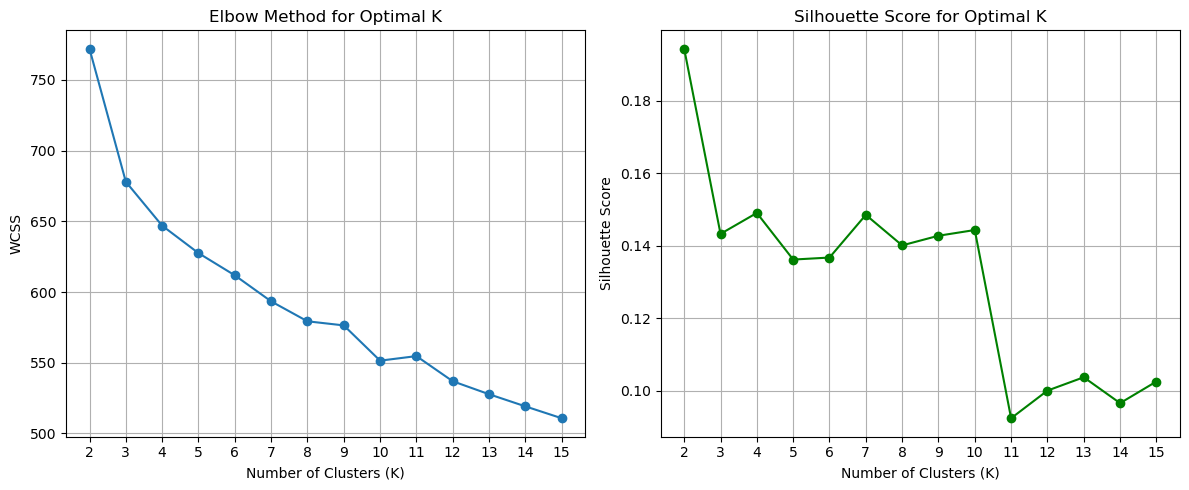


Enter the chosen optimal number of clusters (K):  4



Applying K-Means with K = 4...
Clustering complete. Cluster IDs assigned to DataFrame.
Distribution of series per cluster:
cluster
0    192
3    166
1     53
2     49
Name: count, dtype: int64

--- Phase 3: Audience Clustering Complete ---


In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')

print("\nPhase 3: Starting Audience Clustering...")

if X.empty:
    print("Error: Feature matrix X is empty. Cannot perform clustering. Skipping Phase 3.")
    df['cluster'] = -1
else:
    min_clusters_to_try = 2
    max_clusters_to_test = min(15, X.shape[0] // 2)

    if max_clusters_to_test < min_clusters_to_try:
        print(f"Not enough data points ({X.shape[0]}) to perform meaningful clustering with K > 1. Assigning all to one cluster.")
        OPTIMAL_K = 1
        df['cluster'] = 0
    else:
        wcss = []
        silhouette_scores = []
        
        print(f"Calculating WCSS and Silhouette scores for n_clusters from {min_clusters_to_try} to {max_clusters_to_test}...")
        for i in range(min_clusters_to_try, max_clusters_to_test + 1):
            kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
            kmeans.fit(X)
            wcss.append(kmeans.inertia_)
            
            if i > 1 and X.shape[0] > 1:
                try:
                    silhouette_avg = silhouette_score(X, kmeans.labels_)
                    silhouette_scores.append(silhouette_avg)
                except Exception as e:
                    print(f"Could not calculate silhouette score for {i} clusters: {e}")
                    silhouette_scores.append(0)
            else:
                silhouette_scores.append(0)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(min_clusters_to_try, max_clusters_to_test + 1), wcss, marker='o')
        plt.title('Elbow Method for Optimal K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('WCSS')
        plt.xticks(range(min_clusters_to_try, max_clusters_to_test + 1))
        plt.grid(True)

        plt.subplot(1, 2, 2)
        if len(silhouette_scores) == (max_clusters_to_test - min_clusters_to_try + 1):
            plt.plot(range(min_clusters_to_try, max_clusters_to_test + 1), silhouette_scores, marker='o', color='green')
        elif len(silhouette_scores) > 0:
             plt.plot(range(min_clusters_to_try + (len(range(min_clusters_to_try, max_clusters_to_test + 1)) - len(silhouette_scores)), max_clusters_to_test + 1), silhouette_scores, marker='o', color='green')
        
        plt.title('Silhouette Score for Optimal K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Silhouette Score')
        plt.xticks(range(min_clusters_to_try, max_clusters_to_test + 1))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        try:
            OPTIMAL_K = int(input("\nEnter the chosen optimal number of clusters (K): "))
            if OPTIMAL_K < 1 or OPTIMAL_K > X.shape[0]:
                print(f"Invalid K. K must be between 1 and {X.shape[0]}. Setting K=max_clusters_to_test for demonstration.")
                OPTIMAL_K = max_clusters_to_test
        except ValueError:
            print(f"Invalid input. Setting K=max_clusters_to_test for demonstration.")
            OPTIMAL_K = max_clusters_to_test


    if OPTIMAL_K > 0:
        print(f"\nApplying K-Means with K = {OPTIMAL_K}...")
        kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
        df['cluster'] = kmeans.fit_predict(X)
        print("Clustering complete. Cluster IDs assigned to DataFrame.")
        print(f"Distribution of series per cluster:\n{df['cluster'].value_counts()}")
    else:
        print("Skipping clustering as optimal K is 0 or less (no meaningful clusters).")
        df['cluster'] = 0

print("\n--- Phase 3: Audience Clustering Complete ---")

#### 5. Cluster Interpretation

In [26]:
import pandas as pd 

print("\nPhase 4: Starting Cluster Interpretation and Profile Creation...")

# --- Define numerical_cols here ---
numerical_cols = ['vote_average', 'vote_count', 'popularity', 'number_of_seasons', 'number_of_episodes', 'release_year']


if df['cluster'].isnull().all() or df['cluster'].empty:
    print("No clusters found or DataFrame is empty. Cannot interpret clusters.")
else:
    # --- 1. Top Keywords for Each Cluster ---
    print("\nTop 10 Keywords (TF-IDF) for Each Cluster:")
    for cluster_id in sorted(df['cluster'].unique()):
        if cluster_id == -1: # DBSCAN might assign -1 to noise points, we typically ignore these for personas
            print(f"\n--- Noise Points (Cluster -1) ---")
            cluster_df = df[df['cluster'] == cluster_id]
            if cluster_df.empty: continue
        else:
            print(f"\n--- Cluster {cluster_id} ---")
            cluster_df = df[df['cluster'] == cluster_id]
        
        if cluster_df.empty:
            print("  (No series in this cluster)")
            continue

        # Ensure that the index for X is aligned with df before selection
        cluster_tfidf_avg = X.loc[cluster_df.index, tfidf_vectorizer.get_feature_names_out()].mean(axis=0)
        
        # Check if cluster_tfidf_avg is not all NaNs/zeros before finding nlargest
        if not cluster_tfidf_avg.isnull().all() and not (cluster_tfidf_avg == 0).all():
            top_keywords_idx = cluster_tfidf_avg.nlargest(10).index.tolist()
            print(f"  Keywords: {', '.join(top_keywords_idx)}")
        else:
            print("  (No meaningful keywords for this cluster, possibly due to sparse data)")


    # --- 2. Dominant Genres for Each Cluster ---
    print("\nDominant Genres for Each Cluster:")
    for cluster_id in sorted(df['cluster'].unique()):
        if cluster_id == -1: continue # Skip noise if present
        print(f"\n--- Cluster {cluster_id} ---")
        cluster_df = df[df['cluster'] == cluster_id]
        
        if cluster_df.empty:
            print("  (No series in this cluster)")
            continue

        cluster_genre_avg = X.loc[cluster_df.index, mlb.classes_].mean(axis=0)
        
        if not cluster_genre_avg.isnull().all() and not (cluster_genre_avg == 0).all():
            top_genres = cluster_genre_avg.nlargest(5).index.tolist()
            print(f"  Top Genres: {', '.join(top_genres)}")
        else:
            print("  (No meaningful genres for this cluster)")

    # --- 3. Average Numerical Features for Each Cluster ---
    print("\nAverage Numerical Features for Each Cluster:")
    for cluster_id in sorted(df['cluster'].unique()):
        if cluster_id == -1: continue # Skip noise if present
        print(f"\n--- Cluster {cluster_id} ---")
        cluster_df = df[df['cluster'] == cluster_id]
        
        if cluster_df.empty:
            print("  (No series in this cluster)")
            continue

        # Use the numerical_cols defined at the start of this block
        avg_numerical = cluster_df[numerical_cols].mean()
        print(avg_numerical.to_string())

    # --- 4. Sample Shows for Each Cluster ---
    print("\nSample Shows for Each Cluster (Top 5 by Popularity):")
    for cluster_id in sorted(df['cluster'].unique()):
        if cluster_id == -1: continue # Skip noise if present
        print(f"\n--- Cluster {cluster_id} ---")
        cluster_df = df[df['cluster'] == cluster_id]
        
        if cluster_df.empty:
            print("  (No series in this cluster)")
            continue

        sample_shows = cluster_df.sort_values(by='popularity', ascending=False)['name'].head(5).tolist()
        print(f"  Sample Shows: {', '.join(sample_shows)}")

    # --- Manual Creation of Personas (Based on above insights) ---
    print("\n--- Manual Persona Creation ---")
    print("Based on the keyword analysis, audience personas should be manually defined!")
    
    print("\nThis step requires qualitative analysis of the quantitative outputs.")
    print("\n--- Phase 4: Cluster Interpretation Complete ---")


Phase 4: Starting Cluster Interpretation and Profile Creation...

Top 10 Keywords (TF-IDF) for Each Cluster:

--- Cluster 0 ---
  Keywords: comedy, standup, sitcom, standup comedy, show, love, david, john, lee, de

--- Cluster 1 ---
  Keywords: animation, adult, adult animation, based, anime, david, world, matthew, manga, game

--- Cluster 2 ---
  Keywords: mighty, little, young, animation, magic, based, educational, brown, stephanie, family

--- Cluster 3 ---
  Keywords: love, kim, friendship, family, relationship, romance, lee, christmas, sex, romcom

Dominant Genres for Each Cluster:

--- Cluster 0 ---
  Top Genres: Comedy, Reality, Talk, Family, Mystery

--- Cluster 1 ---
  Top Genres: Animation, Comedy, Sci-Fi & Fantasy, Action & Adventure, Family

--- Cluster 2 ---
  Top Genres: Comedy, Kids, Animation, Family, Action & Adventure

--- Cluster 3 ---
  Top Genres: Comedy, Drama, Crime, Mystery, Sci-Fi & Fantasy

Average Numerical Features for Each Cluster:

--- Cluster 0 ---
vote_

##### 5.1 Extracting and Listing Top Keywords (TF-IDF Scores) for Each Cluster

In [29]:
import pandas as pd

print("\n--- Extracting and Listing Top Keywords (TF-IDF Scores) for Each Cluster ---")

# This check is a safeguard; in a sequential notebook, they should be.
if 'df' not in locals() or 'X' not in locals() or 'tfidf_vectorizer' not in locals() or 'cluster' not in df.columns:
    print("Error: Essential dataframes (df, X) or vectorizer (tfidf_vectorizer) or 'cluster' column not found.")
    print("Please ensure Phase 2 (Data Preprocessing) and Phase 3 (Clustering) have been run successfully.")
    exit() # Or raise an exception, depending on desired behavior

for cluster_id in sorted(df['cluster'].unique()):
    print(f"\n## Cluster {cluster_id}")
    cluster_df = df[df['cluster'] == cluster_id]
    
    if cluster_df.empty:
        print("  (No series in this cluster)")
        continue

    # Select only the TF-IDF features (columns representing keywords) for this cluster's shows.
    # .loc[cluster_df.index, ...] ensures correct alignment between df and X.
    # tfidf_vectorizer.get_feature_names_out() gives the names of the keyword columns.
    cluster_tfidf_features = X.loc[cluster_df.index, tfidf_vectorizer.get_feature_names_out()]
    
    # Calculate the average TF-IDF score for each keyword within this cluster.
    # This represents the overall "importance" of that keyword to the cluster.
    cluster_tfidf_avg = cluster_tfidf_features.mean(axis=0)
    
    # Filter out keywords with 0 or NaN average TF-IDF (can happen if a keyword is very rare in the cluster)
    cluster_tfidf_avg = cluster_tfidf_avg[cluster_tfidf_avg > 0].dropna()

    if not cluster_tfidf_avg.empty:
        # Sort keywords by their average TF-IDF score in descending order and get the top 10.
        top_keywords_with_scores = cluster_tfidf_avg.nlargest(10)

        print("### Top Keywords (TF-IDF Score):")
        for keyword, score in top_keywords_with_scores.items():
            # Format the output for clarity, showing the keyword and its score.
            print(f"- **'{keyword}'**: `{score:.4f}`")
    else:
        print("No distinctive keywords found for this cluster (or all scores are zero).")

print("\n--- Keyword Extraction Complete ---")


--- Extracting and Listing Top Keywords (TF-IDF Scores) for Each Cluster ---

## Cluster 0
### Top Keywords (TF-IDF Score):
- **'comedy'**: `0.0671`
- **'standup'**: `0.0499`
- **'sitcom'**: `0.0424`
- **'standup comedy'**: `0.0379`
- **'show'**: `0.0344`
- **'love'**: `0.0285`
- **'david'**: `0.0269`
- **'john'**: `0.0239`
- **'lee'**: `0.0234`
- **'de'**: `0.0215`

## Cluster 1
### Top Keywords (TF-IDF Score):
- **'animation'**: `0.1346`
- **'adult'**: `0.1035`
- **'adult animation'**: `0.0961`
- **'based'**: `0.0570`
- **'anime'**: `0.0526`
- **'david'**: `0.0389`
- **'world'**: `0.0387`
- **'matthew'**: `0.0337`
- **'manga'**: `0.0330`
- **'game'**: `0.0330`

## Cluster 2
### Top Keywords (TF-IDF Score):
- **'mighty'**: `0.0648`
- **'little'**: `0.0581`
- **'young'**: `0.0448`
- **'animation'**: `0.0448`
- **'magic'**: `0.0446`
- **'based'**: `0.0425`
- **'educational'**: `0.0403`
- **'brown'**: `0.0360`
- **'stephanie'**: `0.0356`
- **'family'**: `0.0356`

## Cluster 3
### Top Ke

##### 5.2 Cluster Visualization

In [32]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.



--- Cluster Visualization ---

Performing PCA for visualization...


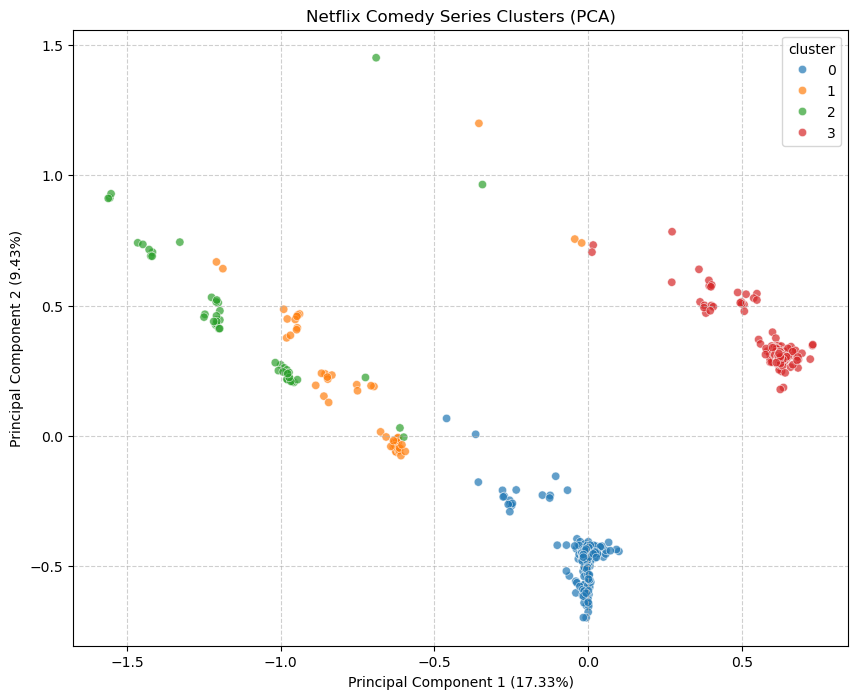

PCA Explained Variance Ratio (2 components): 0.27

Performing t-SNE for visualization (This may take a few moments)...


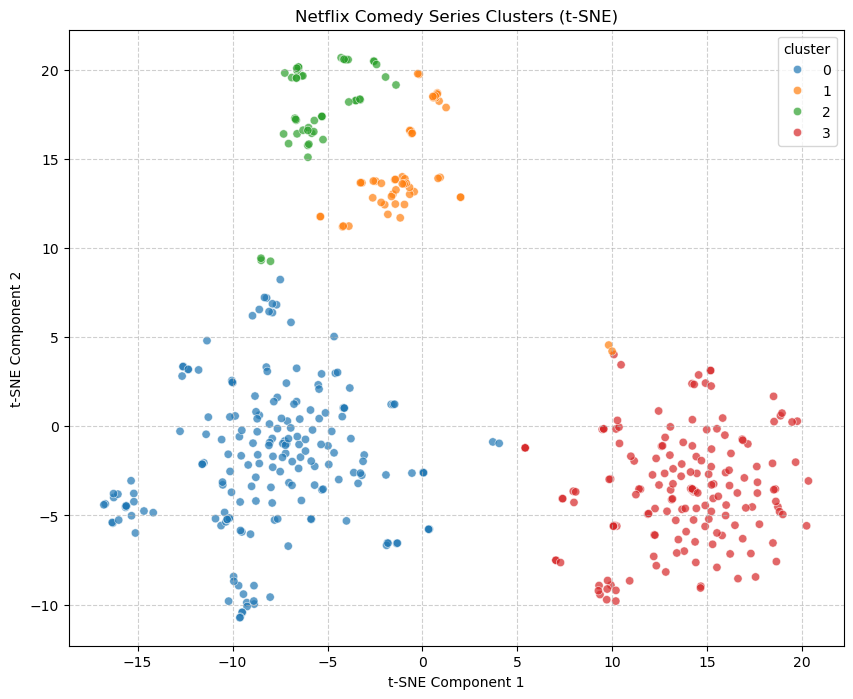


Performing UMAP for visualization...


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


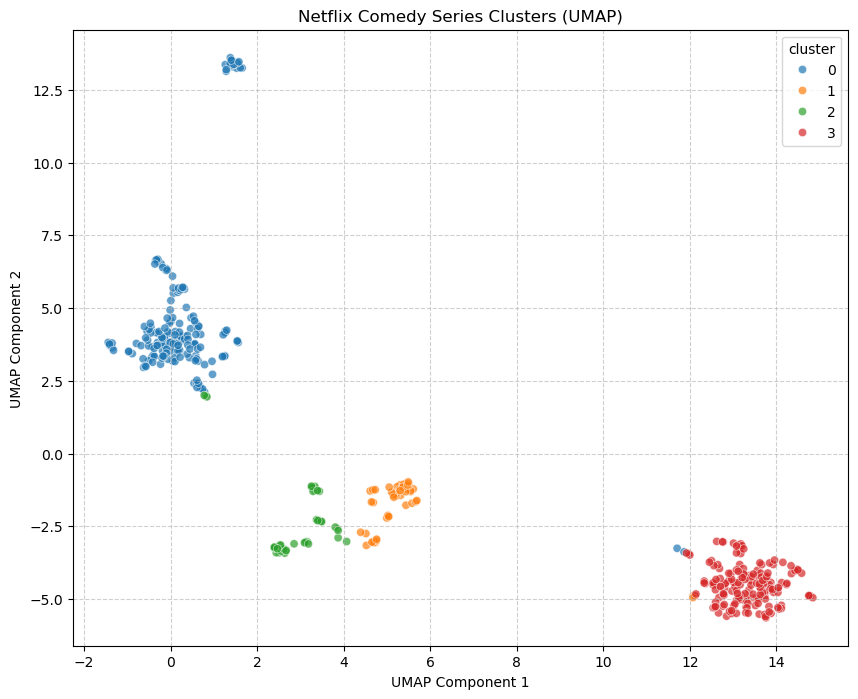


--- Cluster Visualization Complete ---


In [34]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

# Suppress potential FutureWarnings from TSNE for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.manifold._t_sne')

print("\n--- Cluster Visualization ---")

# --- PCA Visualization ---
print("\nPerforming PCA for visualization...")
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X)

df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster'].reset_index(drop=True)
df_pca['name'] = df['name'].reset_index(drop=True) # Adding show names for potential interactive plots

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='cluster',
    palette=sns.color_palette("tab10", n_colors=df['cluster'].nunique()),
    data=df_pca,
    legend='full',
    alpha=0.7
)
plt.title('Netflix Comedy Series Clusters (PCA)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print(f"PCA Explained Variance Ratio (2 components): {pca.explained_variance_ratio_.sum():.2f}")

# --- t-SNE Visualization ---
print("\nPerforming t-SNE for visualization (This may take a few moments)...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=2500, random_state=42, learning_rate='auto', init='random')
tsne_components = tsne.fit_transform(X)

df_tsne = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = df['cluster'].reset_index(drop=True)
df_tsne['name'] = df['name'].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='cluster',
    palette=sns.color_palette("tab10", n_colors=df['cluster'].nunique()),
    data=df_tsne,
    legend='full',
    alpha=0.7
)
plt.title('Netflix Comedy Series Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- UMAP Visualization (Requires umap-learn library: pip install umap-learn) ---
try:
    import umap
    print("\nPerforming UMAP for visualization...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    umap_components = reducer.fit_transform(X)

    df_umap = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])
    df_umap['cluster'] = df['cluster'].reset_index(drop=True)
    df_umap['name'] = df['name'].reset_index(drop=True)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='cluster',
        palette=sns.color_palette("tab10", n_colors=df['cluster'].nunique()),
        data=df_umap,
        legend='full',
        alpha=0.7
    )
    plt.title('Netflix Comedy Series Clusters (UMAP)')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
except ImportError:
    print("\nUMAP library not found. To use UMAP visualization, please install it: pip install umap-learn")

print("\n--- Cluster Visualization Complete ---")

#### 6. Generating Output List

In [37]:
import pandas as pd

print("\nGenerating Output List....")

if 'df' not in locals() or df.empty or 'cluster' not in df.columns:
    print("Error: 'df' DataFrame is not available, is empty, or does not contain the 'cluster' column.")
    print("Please ensure Phase 1, Phase 2, and Phase 3 have been run successfully in this session.")
else:
    # Select the columns you want in your output file.
    # The 'persona' column is NOT generated in the notebook as per your plan.
    output_columns = ['id', 'name', 'first_air_date', 'popularity', 'vote_average', 'cluster']
    
    # Create the output DataFrame with the selected columns
    df_clustered_output = df[output_columns].copy()

    # Define the filename for your CSV
    output_filename = 'netflix_comedy_tv_shows_with_clusters.csv'

    # Save the DataFrame to a CSV file
    df_clustered_output.to_csv(output_filename, index=False)

    print(f"\nSuccessfully downloaded the list of TV shows with clusters to: '{output_filename}'")
    print(f"Number of shows in the list: {len(df_clustered_output)}")
    print("\nHead of the generated CSV file:")
    print(df_clustered_output.head())

print("\n--- Output List Generation Complete ---")


Generating Output List....

Successfully downloaded the list of TV shows with clusters to: 'netflix_comedy_tv_shows_with_clusters.csv'
Number of shows in the list: 460

Head of the generated CSV file:
       id                                  name first_air_date  popularity  \
0  117581                       Ginny & Georgia     2021-02-24    182.6101   
1   80805  The Epic Tales of Captain Underpants     2018-07-13    153.4457   
2   64783                    Dawn of the Croods     2015-12-24    103.7677   
3    1424               Orange Is the New Black     2013-07-11     87.8076   
4   61222                       BoJack Horseman     2014-08-22     83.0742   

   vote_average  cluster  
0         8.067        3  
1         7.500        2  
2         7.400        2  
3         7.658        3  
4         8.545        1  

--- Output List Generation Complete ---
